In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mathsymbol/!_1008.jpg


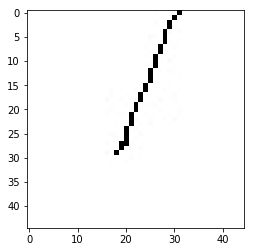

mathsymbol/!_102.jpg


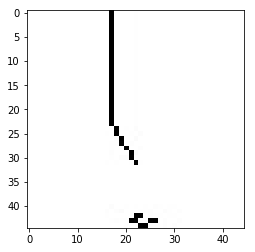

mathsymbol/!_279.jpg


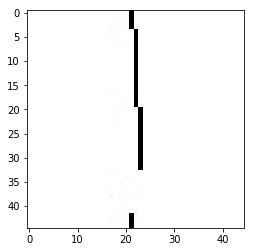

In [3]:
import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))
for i in (12, 25,500):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

In [4]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [5]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128*2, #### CHANGE IF YOU LIKE 128*0.9
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128*2,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128*2,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 1457   576    99   294  1283  1226   622   185   143   699   128    15
    34  2320  3083   271 17284   272  2144 23083   145  6313  1677  1974
  1935  1206    78   402  1435   438    32   344  2009   964   936  1831
   562 10129   237  9295   256  1764 10175   560   499]


In [6]:
#just check if data are loaded correctly
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 256
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 256
break minibatch for-loop


In [7]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [8]:
###############################
### NO NEED TO CHANGE THIS CELL
###############################

def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost



# MODEL 1 --CNN use test set

Epoch: 001/010 | Batch 0000/0432 | Cost: 3.8125
Epoch: 001/010 | Batch 0150/0432 | Cost: 0.2856
Epoch: 001/010 | Batch 0300/0432 | Cost: 0.3769
Epoch: 001/010 | Train: 95.971%
Time elapsed: 22.83 min
Epoch: 002/010 | Batch 0000/0432 | Cost: 0.2264
Epoch: 002/010 | Batch 0150/0432 | Cost: 0.2015
Epoch: 002/010 | Batch 0300/0432 | Cost: 0.1258
Epoch: 002/010 | Train: 97.881%
Time elapsed: 47.28 min
Epoch: 003/010 | Batch 0000/0432 | Cost: 0.1203
Epoch: 003/010 | Batch 0150/0432 | Cost: 0.1271
Epoch: 003/010 | Batch 0300/0432 | Cost: 0.1137
Epoch: 003/010 | Train: 98.450%
Time elapsed: 69.87 min
Epoch: 004/010 | Batch 0000/0432 | Cost: 0.1134
Epoch: 004/010 | Batch 0150/0432 | Cost: 0.0999
Epoch: 004/010 | Batch 0300/0432 | Cost: 0.0946
Epoch: 004/010 | Train: 98.648%
Time elapsed: 92.67 min
Epoch: 005/010 | Batch 0000/0432 | Cost: 0.1091
Epoch: 005/010 | Batch 0150/0432 | Cost: 0.0813
Epoch: 005/010 | Batch 0300/0432 | Cost: 0.1048
Epoch: 005/010 | Train: 98.797%
Time elapsed: 115.49 min

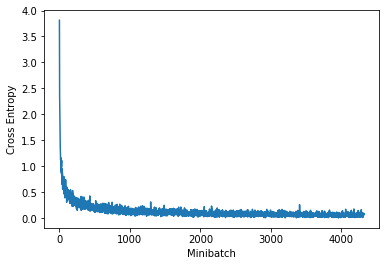

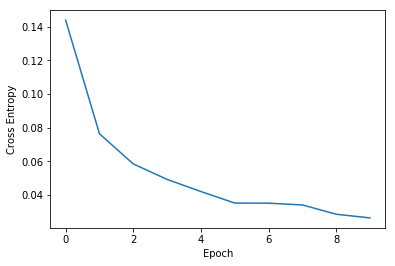

In [12]:
##########################
### MODEL
##########################

class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 4 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=4,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(RANDOM_SEED)

model1 = ConvNet1(NUM_CLASSES)
model1.to(DEVICE)

optimizer = torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model1, train_loader, test_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# Save model

In [13]:
model1.to(torch.device('cpu'))
torch.save(model1.state_dict(),'./my_model1.pt')
#torch.save(optimizer.state_dict(),'/my_optimizer.pt')
#torch.save(scheduler.state_dict(),'/my_scheduler.pt')

# Reuse model

In [1]:
import shutil
from torch.utils.data import Dataset

import os,csv
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 45*45
NUM_CLASSES = 45

# Other
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['Filename'].values
        self.y = df['Class Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [4]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['Class Label'].values))
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128*2, #### CHANGE IF YOU LIKE 128*0.9
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128*2,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='mathsymbol/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128*2,
                         shuffle=False,
                         num_workers=4)

Class distribution Train [ 1457   576    99   294  1283  1226   622   185   143   699   128    15
    34  2320  3083   271 17284   272  2144 23083   145  6313  1677  1974
  1935  1206    78   402  1435   438    32   344  2009   964   936  1831
   562 10129   237  9295   256  1764 10175   560   499]


In [5]:
class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 4 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=4,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [6]:
model=ConvNet1(NUM_CLASSES)
model.load_state_dict(torch.load('./my_model1.pt'))
model=model.to(DEVICE)
#optimizer=torch.optim.SGD(model.paramter(),lr-0.1)
#optimzier.load_state_dict(torch.load('./my_optimizer.pt'))
#scheduler=torch.optim.lr_schedule.ExponentialLR(optimzer,gamma=0.1,last_epoch=-1)
#scheduler.load_state_dict(torch.load('./my_scheduler.pt'))
#model.train()

In [7]:
folders = os.listdir('extracted_images')
class_match = dict()
i = -1
for subfolder in folders:
    i += 1
    class_match[i] = subfolder

True class: (


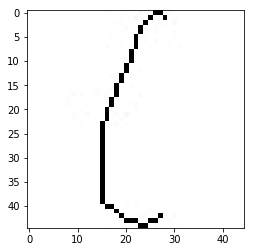

Predict class:  (


,Class,Probability
0,(,9.998968e-01
1,[,1.029030e-04
2,{,2.567890e-07


In [9]:
application_index = [5783]#<=153,354

import glob
image_paths = sorted(glob.glob('mathsymbol/*.jpg'))

with open('application.csv', mode='w') as app:
    app_writer = csv.writer(app, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    app_writer.writerow(['Filename', 'Class Label'])
    for image in application_index:
        app_writer.writerow([image_paths[image].split('/')[1], 0])
    
for i in application_index:
    im_path = image_paths[i]
    print('True class:', im_path.split('/')[1].split('_')[0])
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()
    
application_dataset = QuickdrawDataset(csv_path='application.csv',
                                 img_dir='mathsymbol/',
                                 transform=custom_transform)
application_loader = DataLoader(dataset=application_dataset,
                          batch_size=1, 
                          shuffle=True,
                          num_workers=4)

def predict(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        probas_read = pd.Series(probas.tolist()[0])
        class_label = pd.Series(list(range(NUM_CLASSES)))
        top3 = []
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-1]])[0]], sorted(probas_read)[-1]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-2]])[0]], sorted(probas_read)[-2]]]
        top3 += [[class_match[list(class_label[probas_read == sorted(probas_read)[-3]])[0]], sorted(probas_read)[-3]]]
        top3 = pd.DataFrame(top3)
        _, predicted_labels = torch.max(probas, 1)
        print('Predict class: ', class_match[int(predicted_labels)])
        top3.columns = ['Class', 'Probability']
        return top3

predict(model, application_loader, DEVICE) 

# MODEL 1 --CNN use validation set

In [16]:
def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Test accuracy: %.2f%%' % (compute_accuracy(model, valid_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost




In [17]:
class ConvNet1(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(ConvNet1, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 17 stride 4 ==>32*12*12
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=4,padding=1)#((12-1)*4+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*12*12  kernel 5 stride 3 ==>256*4*4
        self.conv1 =  nn.Conv2d(32, 256, kernel_size=3, stride=3, padding=0)#((4-1)*3+3-12)/2
        self.bn1=torch.nn.BatchNorm2d(256)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*1*1
        self.conv2 =  nn.Conv2d(256, 256, kernel_size=4, stride=3, padding=0)#((1-1)*3+4-4)/2
        self.bn2=torch.nn.BatchNorm2d(256)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        
        self.linear1=torch.nn.Linear(256, 4096)
        self.bn3=torch.nn.BatchNorm1d(4096)
        self.drop3=torch.nn.Dropout(0.4)
        
        self.linear2=torch.nn.Linear(4096,4096)
        self.bn4=torch.nn.BatchNorm1d(4096)
        self.drop4=torch.nn.Dropout(0.4)
        
        self.linear3 = nn.Linear(4096, NUM_CLASSES)  

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=self.drop0(out)
        out=F.relu(out)
        
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=self.drop1(out)
        out=F.relu(out)
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=self.drop2(out)
        out=F.relu(out)
        
        out=out.view(out.size(0), -1)
        
        
        out = self.linear1(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.drop3(out)
        
        
        
        out = self.linear2(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.drop4(out)
        
        
        logits = self.linear3(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

Epoch: 001/010 | Batch 0000/0432 | Cost: 3.8125
Epoch: 001/010 | Batch 0150/0432 | Cost: 0.2856
Epoch: 001/010 | Batch 0300/0432 | Cost: 0.3769
Epoch: 001/010 | Train: 95.971%
Time elapsed: 37.08 min
Epoch: 002/010 | Batch 0000/0432 | Cost: 0.2264
Epoch: 002/010 | Batch 0150/0432 | Cost: 0.2015
Epoch: 002/010 | Batch 0300/0432 | Cost: 0.1258
Epoch: 002/010 | Train: 97.881%
Time elapsed: 64.52 min
Epoch: 003/010 | Batch 0000/0432 | Cost: 0.1203
Epoch: 003/010 | Batch 0150/0432 | Cost: 0.1271
Epoch: 003/010 | Batch 0300/0432 | Cost: 0.1137
Epoch: 003/010 | Train: 98.450%
Time elapsed: 94.65 min
Epoch: 004/010 | Batch 0000/0432 | Cost: 0.1134
Epoch: 004/010 | Batch 0150/0432 | Cost: 0.0999
Epoch: 004/010 | Batch 0300/0432 | Cost: 0.0946
Epoch: 004/010 | Train: 98.648%
Time elapsed: 121.30 min
Epoch: 005/010 | Batch 0000/0432 | Cost: 0.1091
Epoch: 005/010 | Batch 0150/0432 | Cost: 0.0813
Epoch: 005/010 | Batch 0300/0432 | Cost: 0.1048
Epoch: 005/010 | Train: 98.797%
Time elapsed: 150.02 mi

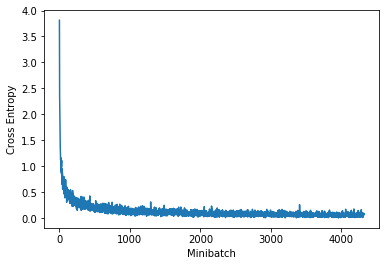

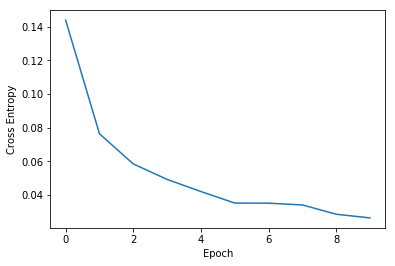

In [19]:
torch.manual_seed(RANDOM_SEED)

model2 = ConvNet1(NUM_CLASSES)
model2.to(DEVICE)

optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

minibatch_cost, epoch_cost = train(model2, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

# save model

In [20]:
model2.to(torch.device('cpu'))
torch.save(model2.state_dict(),'./my_model2.pt')

# NIN 

In [9]:
def train(model, train_loader, test_loader):

    minibatch_cost, epoch_cost = [], []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()
            minibatch_cost.append(cost)

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 150:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), cost))

    
        with torch.set_grad_enabled(False): # save memory during inference
            print('Epoch: %03d/%03d | Train: %.3f%%' % (
                  epoch+1, NUM_EPOCHS, 
                  compute_accuracy(model, train_loader, device=DEVICE)))
            
            cost = compute_epoch_loss(model, train_loader)
            epoch_cost.append(cost)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


    with torch.set_grad_enabled(False): # save memory during inference
        print('Valid accuracy: %.2f%%' % (compute_accuracy(model, valid_loader, device=DEVICE)))

    print('Total Time: %.2f min' % ((time.time() - start_time)/60))
    
    return minibatch_cost, epoch_cost



In [10]:
class nin(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(nin, self).__init__()
        
        #### YOUR CODE
        #1*45*45 kernel 3 stride 2 ==>32*24*24
        self.conv0 = nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=2)#((24-1)*2+3-45)/2
        self.bn0=torch.nn.BatchNorm2d(32)
        self.pool0=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.drop0=torch.nn.Dropout2d(0.2)
        
        #32*24*24 kernel 3 stride 2 ==>32*12*12
        self.conv1 = nn.Conv2d(32, 32, kernel_size=4, stride=2,padding=1)#((12-1)*2+4-24)/2
        self.bn1=torch.nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.drop1=torch.nn.Dropout2d(0.2)
        
        #32*12*12 kernel 3 stride 2 ==>32*6*6
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2,padding=1)#((6-1)*2+4-12)/2
        self.bn2=torch.nn.BatchNorm2d(32)
        self.pool2=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.drop2=torch.nn.Dropout2d(0.2)
        
        #32*6*6  kernel 3 stride 3 ==>256*4*4
        self.conv3 =  nn.Conv2d(32, 256, kernel_size=4, stride=3, padding=0)#((4-1)*3+4-12)/2
        self.bn3=torch.nn.BatchNorm2d(256)
        self.avgpool3=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.drop3=torch.nn.Dropout2d(0.2)
        
        #256*4*4  kernel 5 stride 3 ==>256*2*2
        self.conv4 =  nn.Conv2d(256, 256, kernel_size=2, stride=3, padding=0)#((2-1)*3+2-4)/2
        self.bn4=torch.nn.BatchNorm2d(256)
        self.avgpool4=nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        

    def forward(self, x):

        #### YOUR CODE
        #print(x.size())
        out = self.conv0(x)
        #print(out.size())
        out=self.bn0(out)
        out=F.relu(out)
        
        out = self.conv1(out)
        #print(out.size())
        out=self.bn1(out)
        out=F.relu(out)
        out=self.pool1(out)
        out=self.drop1(out)
        #print(out.size())
        
        out = self.conv2(out)
        #print(out.size())
        out=self.bn2(out)
        out=F.relu(out)
        #print(out.size())
        
        out = self.conv3(out)
        #print(out.size())
        out=self.bn3(out)
        out=F.relu(out)
        out=self.avgpool3(out)
        out=self.drop3(out)
        #print(out.size())
        
        out = self.conv4(out)
        #print(out.size())
        out=self.bn4(out)
        out=F.relu(out)
        out=self.avgpool4(out)
        #print(out.size())
        
        out=out.view(out.size(0), -1)
        
        
        
        
        
        logits = out
        probas = F.softmax(logits, dim=1)
        return logits, probas

Epoch: 001/010 | Batch 0000/0432 | Cost: 5.5462
Epoch: 001/010 | Batch 0150/0432 | Cost: 5.2783
Epoch: 001/010 | Batch 0300/0432 | Cost: 5.1732
Epoch: 001/010 | Train: 94.418%
Time elapsed: 9.84 min
Epoch: 002/010 | Batch 0000/0432 | Cost: 5.0863
Epoch: 002/010 | Batch 0150/0432 | Cost: 4.9970
Epoch: 002/010 | Batch 0300/0432 | Cost: 4.9321
Epoch: 002/010 | Train: 96.994%
Time elapsed: 19.60 min
Epoch: 003/010 | Batch 0000/0432 | Cost: 4.8422
Epoch: 003/010 | Batch 0150/0432 | Cost: 4.7743
Epoch: 003/010 | Batch 0300/0432 | Cost: 4.6643
Epoch: 003/010 | Train: 97.905%
Time elapsed: 29.75 min
Epoch: 004/010 | Batch 0000/0432 | Cost: 4.5718
Epoch: 004/010 | Batch 0150/0432 | Cost: 4.4643
Epoch: 004/010 | Batch 0300/0432 | Cost: 4.3851
Epoch: 004/010 | Train: 98.503%
Time elapsed: 39.61 min
Epoch: 005/010 | Batch 0000/0432 | Cost: 4.4122
Epoch: 005/010 | Batch 0150/0432 | Cost: 4.3201
Epoch: 005/010 | Batch 0300/0432 | Cost: 4.2342
Epoch: 005/010 | Train: 98.602%
Time elapsed: 49.47 min
E

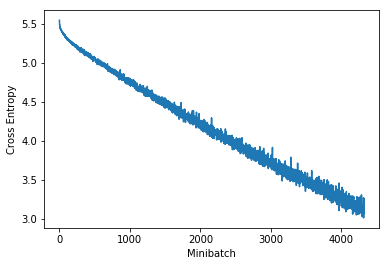

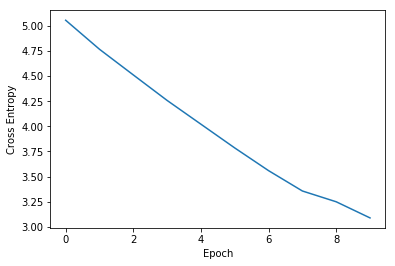

In [11]:
torch.manual_seed(RANDOM_SEED)


model = nin(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 


minibatch_cost, epoch_cost = train(model, train_loader, valid_loader)


plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [12]:
model.to(torch.device('cpu'))
torch.save(model.state_dict(),'./my_model_nin.pt')